## Preparation

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from mordred import Calculator, descriptors

import re
import phik
from umap import UMAP

from IPython.display import clear_output

In [9]:
import sklearn
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [10]:
from rdkit.Chem import AllChem, DataStructs

In [11]:
np.float = np.float64

## FPPS

### Cleaning

In [12]:
df = pd.read_csv('../data/raw_data/fpps.csv', sep=';')
df.columns = [col.lower().replace(' ', '_') for col in df.columns]
df = df[[
    'molecule_chembl_id', 'molecular_weight', 'alogp',
    'smiles', 'standard_relation', 'standard_value',
    'standard_units', 'data_validity_comment', 'assay_description',
    'assay_organism',
]]

In [13]:
df.head()

,molecule_chembl_id,molecular_weight,alogp,smiles,standard_relation,standard_value,standard_units,data_validity_comment,assay_description,assay_organism
0,CHEMBL323299,286.12,-0.74,Cc1nc(CC(O)(P(=O)(O)O)P(=O)(O)O)c[nH]1,'=',50.82,nM,NaN,Negative logarithm of inhibitory concentration...,Rattus norvegicus
1,CHEMBL392675,280.18,-1.38,C[S+](C)CCC(O)(P(=O)([O-])O)P(=O)(O)O,'=',10000.00,nM,NaN,Inhibition of human FPPS,Homo sapiens
2,CHEMBL299717,233.10,-0.38,CCCNC(P(=O)(O)O)P(=O)(O)O,'=',1659.59,nM,NaN,Inhibitory activity against farnesyl Pyrophosp...,Leishmania major
3,CHEMBL412889,301.22,1.33,O=P(O)(O)C(NC1CCCCCCC1)P(=O)(O)O,'=',2454.71,nM,NaN,Inhibitory activity against farnesyl Pyrophosp...,Leishmania major
4,CHEMBL55464,367.28,0.99,O=P(O)(O)C(O)(CCNCCCCc1ccccc1)P(=O)(O)O,'=',250.00,nM,NaN,Inhibitory activity against farnesyl Pyrophosp...,Leishmania major


In [14]:
df = df[df['assay_organism'] == 'Homo sapiens']
df = df[df['data_validity_comment'] != 'Outside typical range']
df = df[df['data_validity_comment'] != 'Potential transcription error']
df = df[df['standard_units'] == 'nM']

In [15]:
df = df[df['standard_relation'] == "'='"]
df = df[['molecular_weight', 'smiles', 'standard_value', 'alogp']]
df['standard_value'] = np.log(df['standard_value'])

In [16]:
df = df[df['alogp'] != 'None']
df['alogp'] = df['alogp'].astype(float)

In [17]:
mean_sv = df.groupby('smiles')['standard_value'].mean()
df = df[~df['smiles'].duplicated()]
df = df.set_index('smiles')
df['standard_value'] = mean_sv

df = df.reset_index()

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   smiles            238 non-null    object 
 1   molecular_weight  238 non-null    float64
 2   standard_value    238 non-null    float64
 3   alogp             238 non-null    float64
dtypes: float64(3), object(1)
memory usage: 7.6+ KB


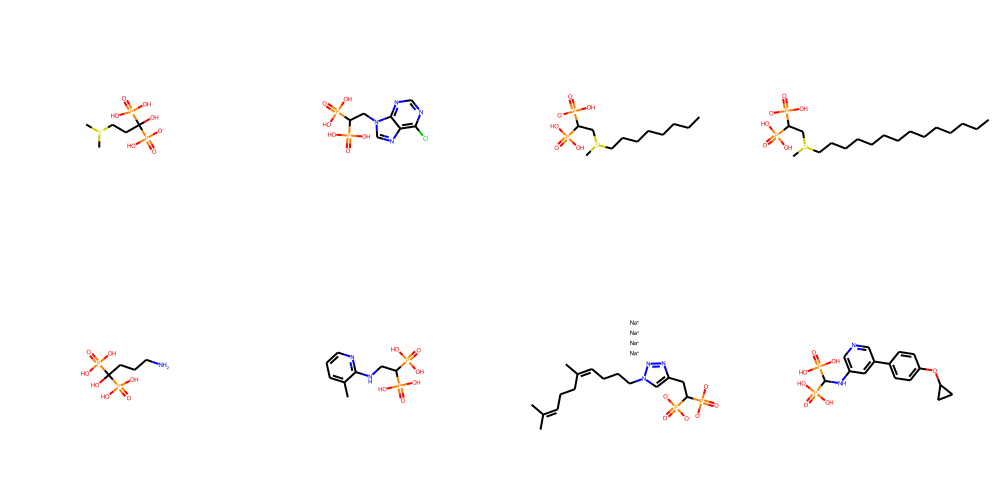

In [19]:
molecules = [Chem.MolFromSmiles(smiles) for smiles in df['smiles']][:8]
Draw.MolsToGridImage(molecules, molsPerRow=4, subImgSize=(250,250))

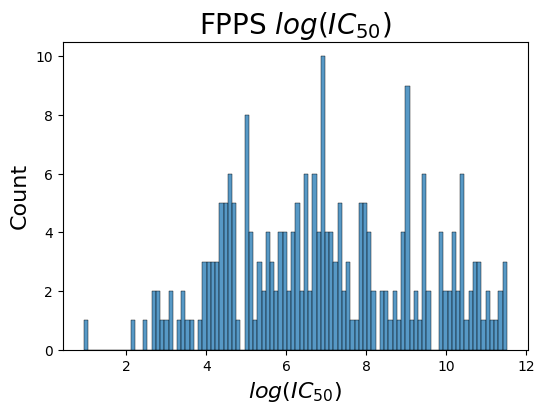

In [20]:
plt.figure(figsize=(6, 4))
sns.histplot(data=df, x='standard_value', bins=100)
plt.ylabel('Count', size=16)
plt.xlabel('$log(IC_{50})$', size=16) 
plt.title('FPPS $log(IC_{50})$', size=20) 
  
# Display figure 
plt.show() 

In [21]:
df.to_csv('../data/clean_data/fpps_cl.csv')

### Descryption

In [22]:
def get_descr_value(molecule, descr_func):
    out_arr = np.zeros((1,), dtype=int)
    descriptor = descr_func(molecule)
    if isinstance(descriptor, rdkit.DataStructs.cDataStructs.ExplicitBitVect):
        DataStructs.ConvertToNumpyArray(descriptor, out_arr)
        return out_arr
    return descriptor

def All_Mordred_descriptors(data):
    calc = Calculator(descriptors, ignore_3D=False)
    mols = [Chem.MolFromSmiles(smi) for smi in data]
    df = calc.pandas(mols)
    return df

def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()

    Mol_descriptors =[]
    for mol in mols:
        mol=Chem.AddHs(mol)
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors, desc_names   

def get_descr_df(df):
    mols = [Chem.MolFromSmiles(smile) for smile in df['smiles']]
    fps = []
    col = [f'mor_{i}' for i in range(1024)]
    col.extend([f'mac_{i}' for i in range(167)])
    df_clust = df.copy()
    
    # mor+mac
    for i in range(len(mols)):
        mac = get_descr_value(mols[i], AllChem.GetMACCSKeysFingerprint)
        mor = np.array(AllChem.GetMorganFingerprintAsBitVect(mols[i], radius=3, useFeatures=False, nBits=1024))
        fps.append(np.concatenate([mor, mac]))
    fps = np.array(fps)
    
    #mordred
    mordred_descriptors = All_Mordred_descriptors(df['smiles'])
    mordred_descriptors = mordred_descriptors.drop(columns=mordred_descriptors.columns[mordred_descriptors.dtypes == object])
    mordred_descriptors = mordred_descriptors.drop(columns=mordred_descriptors.columns[mordred_descriptors.dtypes == bool])
    mordred_descriptors = mordred_descriptors.dropna(axis=1)
    
    #rdkit
    Mol_descriptors, desc_names = RDkit_descriptors(df['smiles'])
    Mol_descriptors = pd.DataFrame(Mol_descriptors).dropna(axis=1)
    Mol_descriptors.columns = [f'rdkit_{i}' for i in range(len(Mol_descriptors.columns))]
    
    df_clust = pd.concat([
        df_clust,
        pd.DataFrame(columns=col, data=fps)],
        axis=1)
    df_clust = pd.concat([df_clust, Mol_descriptors, mordred_descriptors], axis=1)
    df_clust.columns = [str(col) for col in df_clust.columns]
    
    df_clust = df_clust.drop(columns=['molecular_weight', 'alogp'])
    return df_clust

In [23]:
df_descr = get_descr_df(df)

100%|██████████| 238/238 [00:17<00:00, 13.24it/s]


In [24]:
df_descr.to_csv('../data/desc_data/fpps_desc.csv', index=False)

### Checking charge

In [25]:
from rdkit import Chem
import ase
from ase import Atoms
from ase.optimize import BFGS
from ase.calculators.nwchem import NWChem
from ase.io import write
from xtb.ase.calculator import XTB

from tqdm.autonotebook import tqdm

In [26]:
df = pd.read_csv('../data/clean_data/fpps_cl.csv')

In [27]:
def get_charges(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        AllChem.UFFOptimizeMolecule(mol)
        atoms = []
        positions = []
        for i, atom in enumerate(mol.GetAtoms()):
            pos = mol.GetConformer().GetAtomPosition(i)
            atoms.append(atom.GetAtomicNum())
            positions.append([pos.x, pos.y, pos.z])

        mol_calc = Atoms(numbers=atoms, positions=positions)
        mol_calc.calc = XTB(method="GFN2-xTB")
        opt = BFGS(mol_calc)
        opt.run(fmax=0.05)
        mol.charges = mol_calc.get_charges()
        mol.charges_g = True
    except:
        mol.charges_g = False
        return mol
    return mol

In [28]:
charges = []
for smiles in tqdm(df['smiles']):
    sup = []
    mol = get_charges(smiles)
    if not mol.charges_g:
        charges.append([0,0,0])
        continue
    
    patt = Chem.MolFromSmarts('P(=O)(O)O')
    if mol.HasSubstructMatch(patt):
        sup.append(mol.charges[mol.GetSubstructMatch(patt)[1]].item())
    else:
        sup.append(0)

    patt = Chem.MolFromSmarts('P***[#7]')
    if mol.HasSubstructMatch(patt):
        sup.append(mol.charges[mol.GetSubstructMatch(patt)[-1]].item())
    else:
        sup.append(0)
    
    patt = Chem.MolFromSmarts('P****[#7]')
    if mol.HasSubstructMatch(patt):
        sup.append(mol.charges[mol.GetSubstructMatch(patt)[-1]].item())
    else:
        sup.append(0)
    charges.append(sup)

BFGS:    4 17:52:18    -2601.170393        0.5773
BFGS:    5 17:52:18    -2601.229721        0.4582
BFGS:    6 17:52:19    -2601.300078        0.4859
BFGS:    7 17:52:20    -2601.340819        0.4234
BFGS:    8 17:52:20    -2601.374138        0.3405
BFGS:    9 17:52:21    -2601.403043        0.3410
BFGS:   10 17:52:22    -2601.433203        0.2868
BFGS:   11 17:52:23    -2601.459268        0.2491
BFGS:   12 17:52:23    -2601.477402        0.2465
BFGS:   13 17:52:24    -2601.489906        0.2202
BFGS:   14 17:52:25    -2601.501743        0.1979
BFGS:   15 17:52:25    -2601.513928        0.1958
BFGS:   16 17:52:26    -2601.524745        0.1485
BFGS:   17 17:52:27    -2601.533767        0.1401
BFGS:   18 17:52:27    -2601.541921        0.1386
BFGS:   19 17:52:28    -2601.549783        0.1419
BFGS:   20 17:52:28    -2601.557005        0.1311
BFGS:   21 17:52:29    -2601.563576        0.1250
BFGS:   22 17:52:30    -2601.569819        0.1345
BFGS:   23 17:52:30    -2601.575896        0.1532


 81%|████████  | 193/238 [2:26:57<29:23, 39.19s/it]

      Step     Time          Energy         fmax
BFGS:    0 17:52:42    -1913.908697        2.1132
BFGS:    1 17:52:43    -1914.193470        1.2340
BFGS:    2 17:52:43    -1914.376712        0.9355
BFGS:    3 17:52:44    -1914.514303        0.5155
BFGS:    4 17:52:44    -1914.598326        0.3450
BFGS:    5 17:52:45    -1914.644689        0.4142
BFGS:    6 17:52:46    -1914.683156        0.4489
BFGS:    7 17:52:46    -1914.713156        0.3951
BFGS:    8 17:52:47    -1914.737285        0.3119
BFGS:    9 17:52:47    -1914.757403        0.2261
BFGS:   10 17:52:48    -1914.774884        0.2035
BFGS:   11 17:52:48    -1914.789187        0.2074
BFGS:   12 17:52:49    -1914.800543        0.2026
BFGS:   13 17:52:50    -1914.809908        0.1836
BFGS:   14 17:52:50    -1914.818438        0.1728
BFGS:   15 17:52:51    -1914.826117        0.1503
BFGS:   16 17:52:51    -1914.832774        0.1344
BFGS:   17 17:52:52    -1914.838704        0.1325
BFGS:   18 17:52:52    -1914.844152        0.1331
B

 82%|████████▏ | 194/238 [2:27:17<24:38, 33.61s/it]

      Step     Time          Energy         fmax
BFGS:    0 17:53:02    -1969.851565        4.3975
BFGS:    1 17:53:03    -1970.216388        4.6371
BFGS:    2 17:53:04    -1970.474294        1.0843
BFGS:    3 17:53:05    -1970.654189        1.0310
BFGS:    4 17:53:05    -1970.798890        1.0205
BFGS:    5 17:53:06    -1970.844774        0.4228
BFGS:    6 17:53:06    -1970.884997        0.4376
BFGS:    7 17:53:07    -1970.912058        0.4612
BFGS:    8 17:53:08    -1970.938394        0.3077
BFGS:    9 17:53:08    -1970.957040        0.2305
BFGS:   10 17:53:09    -1970.973009        0.2459
BFGS:   11 17:53:09    -1970.984950        0.2567
BFGS:   12 17:53:10    -1970.993806        0.1518
BFGS:   13 17:53:10    -1971.000345        0.1361
BFGS:   14 17:53:11    -1971.005549        0.1489
BFGS:   15 17:53:12    -1971.009965        0.1304
BFGS:   16 17:53:12    -1971.013985        0.1256
BFGS:   17 17:53:13    -1971.018051        0.1196
BFGS:   18 17:53:13    -1971.022068        0.1683
B

 82%|████████▏ | 195/238 [2:27:36<20:50, 29.08s/it]

      Step     Time          Energy         fmax
BFGS:    0 17:53:21    -2485.171387        3.8709
BFGS:    1 17:53:22    -2485.956441        2.7281
BFGS:    2 17:53:23    -2486.320922        1.2589
BFGS:    3 17:53:24    -2486.516762        1.2819
BFGS:    4 17:53:24    -2486.603942        1.0049
BFGS:    5 17:53:25    -2486.659124        0.4405
BFGS:    6 17:53:26    -2486.687229        0.4409
BFGS:    7 17:53:26    -2486.716627        0.4550
BFGS:    8 17:53:27    -2486.739602        0.3876
BFGS:    9 17:53:28    -2486.767137        0.3805
BFGS:   10 17:53:28    -2486.802663        0.5822
BFGS:   11 17:53:29    -2486.844515        0.5560
BFGS:   12 17:53:30    -2486.881732        0.4800
BFGS:   13 17:53:31    -2486.910816        0.3925
BFGS:   14 17:53:32    -2486.938209        0.3796
BFGS:   15 17:53:32    -2486.977245        0.5852
BFGS:   16 17:53:33    -2487.021763        0.6173
BFGS:   17 17:53:34    -2487.056584        0.6849
BFGS:   18 17:53:34    -2487.081689        0.7341
B

 83%|████████▎ | 198/238 [2:28:17<10:42, 16.06s/it]

      Step     Time          Energy         fmax
BFGS:    0 17:54:02    -2242.316625        4.1115
BFGS:    1 17:54:03    -2242.760930        4.9669
BFGS:    2 17:54:04    -2243.133899        1.1866
BFGS:    3 17:54:04    -2243.313295        0.9706
BFGS:    4 17:54:05    -2243.461477        0.9493
BFGS:    5 17:54:06    -2243.541291        0.7251
BFGS:    6 17:54:06    -2243.617869        0.6023
BFGS:    7 17:54:07    -2243.656311        1.0012
BFGS:    8 17:54:08    -2243.694849        0.5784
BFGS:    9 17:54:08    -2243.732720        0.3813
BFGS:   10 17:54:09    -2243.770519        0.4064
BFGS:   11 17:54:10    -2243.796134        0.3665
BFGS:   12 17:54:10    -2243.820083        0.3417
BFGS:   13 17:54:11    -2243.840524        0.3758
BFGS:   14 17:54:11    -2243.859347        0.3062
BFGS:   15 17:54:12    -2243.875653        0.2423
BFGS:   16 17:54:13    -2243.889581        0.2397
BFGS:   17 17:54:13    -2243.901366        0.2514
BFGS:   18 17:54:14    -2243.912297        0.2245
B

 84%|████████▍ | 200/238 [2:28:47<08:58, 14.18s/it]

      Step     Time          Energy         fmax
BFGS:    0 17:54:32    -2004.577165        4.8828
BFGS:    1 17:54:33    -2005.399076        4.2008
BFGS:    2 17:54:34    -2005.823819        1.3192
BFGS:    3 17:54:34    -2006.097865        1.9354
BFGS:    4 17:54:35    -2006.245023        1.2903
BFGS:    5 17:54:36    -2006.317754        0.5508
BFGS:    6 17:54:36    -2006.365656        0.7878
BFGS:    7 17:54:37    -2006.422693        0.9188
BFGS:    8 17:54:37    -2006.469690        0.7231
BFGS:    9 17:54:38    -2006.507729        0.3764
BFGS:   10 17:54:39    -2006.537564        0.3818
BFGS:   11 17:54:39    -2006.558609        0.3722
BFGS:   12 17:54:40    -2006.572277        0.2735
BFGS:   13 17:54:40    -2006.583536        0.2734
BFGS:   14 17:54:41    -2006.597372        0.3240
BFGS:   15 17:54:41    -2006.614684        0.3759
BFGS:   16 17:54:42    -2006.634777        0.3321
BFGS:   17 17:54:43    -2006.656079        0.3287
BFGS:   18 17:54:43    -2006.678586        0.4046
B

 84%|████████▍ | 201/238 [2:29:39<15:46, 25.59s/it]

      Step     Time          Energy         fmax
BFGS:    0 17:55:24    -1665.556499        5.1162
BFGS:    1 17:55:25    -1666.496750        4.2463
BFGS:    2 17:55:26    -1666.940554        1.4649
BFGS:    3 17:55:26    -1667.195957        1.4289
BFGS:    4 17:55:27    -1667.333019        1.1303
BFGS:    5 17:55:28    -1667.391273        0.5032
BFGS:    6 17:55:28    -1667.426222        0.4618
BFGS:    7 17:55:29    -1667.463310        0.6741
BFGS:    8 17:55:30    -1667.498238        0.5488
BFGS:    9 17:55:30    -1667.531230        0.6450
BFGS:   10 17:55:31    -1667.574057        0.6592
BFGS:   11 17:55:32    -1667.627767        0.7968
BFGS:   12 17:55:32    -1667.681207        0.6785
BFGS:   13 17:55:33    -1667.730241        0.5653
BFGS:   14 17:55:33    -1667.774574        0.5112
BFGS:   15 17:55:34    -1667.812067        0.4940
BFGS:   16 17:55:35    -1667.838890        0.3888
BFGS:   17 17:55:35    -1667.858641        0.3761
BFGS:   18 17:55:36    -1667.872282        0.5270
B

 85%|████████▍ | 202/238 [2:30:00<14:34, 24.29s/it]

      Step     Time          Energy         fmax
BFGS:    0 17:55:45    -2070.727724        5.0909
BFGS:    1 17:55:46    -2071.727572        4.3297
BFGS:    2 17:55:47    -2072.178636        1.4614
BFGS:    3 17:55:48    -2072.420990        1.5093
BFGS:    4 17:55:49    -2072.593309        0.9419
BFGS:    5 17:55:49    -2072.663409        0.5097
BFGS:    6 17:55:50    -2072.705725        0.5003
BFGS:    7 17:55:51    -2072.750262        0.7278
BFGS:    8 17:55:51    -2072.786700        0.5717
BFGS:    9 17:55:52    -2072.810664        0.3789
BFGS:   10 17:55:53    -2072.835233        0.3990
BFGS:   11 17:55:53    -2072.865882        0.4696
BFGS:   12 17:55:54    -2072.897501        0.3827
BFGS:   13 17:55:55    -2072.924803        0.3708
BFGS:   14 17:55:56    -2072.946176        0.3322
BFGS:   15 17:55:56    -2072.964501        0.3715
BFGS:   16 17:55:57    -2072.982447        0.3014
BFGS:   17 17:55:57    -2073.000969        0.2906
BFGS:   18 17:55:58    -2073.019799        0.5649
B

 85%|████████▌ | 203/238 [2:30:33<15:36, 26.77s/it]

      Step     Time          Energy         fmax
BFGS:    0 17:56:18    -3076.551636        3.8579
BFGS:    1 17:56:19    -3077.285743        3.9201
BFGS:    2 17:56:20    -3077.578410        1.1049
BFGS:    3 17:56:21    -3077.730292        0.8296
BFGS:    4 17:56:22    -3077.895547        0.5701
BFGS:    5 17:56:22    -3077.976124        0.6417
BFGS:    6 17:56:23    -3078.065150        0.6328
BFGS:    7 17:56:24    -3078.117607        0.6475
BFGS:    8 17:56:25    -3078.168074        0.5037
BFGS:    9 17:56:26    -3078.214977        0.3596
BFGS:   10 17:56:26    -3078.252092        0.2806
BFGS:   11 17:56:27    -3078.283644        0.2699
BFGS:   12 17:56:28    -3078.310714        0.3367
BFGS:   13 17:56:29    -3078.329496        0.2319
BFGS:   14 17:56:29    -3078.343650        0.1714
BFGS:   15 17:56:30    -3078.355732        0.1691
BFGS:   16 17:56:31    -3078.367416        0.2113
BFGS:   17 17:56:32    -3078.378907        0.1902
BFGS:   18 17:56:32    -3078.390045        0.1730
B

 87%|████████▋ | 207/238 [2:31:00<05:15, 10.19s/it]

      Step     Time          Energy         fmax
BFGS:    0 17:56:46    -2417.539714        3.1213
BFGS:    1 17:56:46    -2417.996093        2.7264
BFGS:    2 17:56:47    -2418.224757        1.4574
BFGS:    3 17:56:48    -2418.385650        0.7491
BFGS:    4 17:56:49    -2418.498440        0.4902
BFGS:    5 17:56:49    -2418.556868        0.5170
BFGS:    6 17:56:50    -2418.627501        0.4793
BFGS:    7 17:56:51    -2418.663006        0.3942
BFGS:    8 17:56:51    -2418.694356        0.3226
BFGS:    9 17:56:52    -2418.721916        0.2923
BFGS:   10 17:56:53    -2418.751324        0.3209
BFGS:   11 17:56:53    -2418.775463        0.2488
BFGS:   12 17:56:54    -2418.792613        0.2468
BFGS:   13 17:56:55    -2418.805500        0.2160
BFGS:   14 17:56:55    -2418.817814        0.1690
BFGS:   15 17:56:56    -2418.829920        0.1487
BFGS:   16 17:56:57    -2418.840292        0.1783
BFGS:   17 17:56:57    -2418.849027        0.1391
BFGS:   18 17:56:58    -2418.857085        0.1470
B

 87%|████████▋ | 208/238 [2:31:26<07:05, 14.17s/it]

      Step     Time          Energy         fmax
BFGS:    0 17:57:12    -2235.060474        4.2130
BFGS:    1 17:57:13    -2235.429907        5.3009
BFGS:    2 17:57:13    -2235.792540        1.0620
BFGS:    3 17:57:14    -2235.927659        0.9039
BFGS:    4 17:57:15    -2236.122450        0.6814
BFGS:    5 17:57:16    -2236.182305        0.6133
BFGS:    6 17:57:16    -2236.293030        0.5400
BFGS:    7 17:57:17    -2236.331980        0.6787
BFGS:    8 17:57:17    -2236.365946        0.5151
BFGS:    9 17:57:18    -2236.391273        0.4720
BFGS:   10 17:57:19    -2236.414891        0.3109
BFGS:   11 17:57:19    -2236.432711        0.2480
BFGS:   12 17:57:20    -2236.447364        0.2676
BFGS:   13 17:57:20    -2236.465304        0.4124
BFGS:   14 17:57:21    -2236.481292        0.3308
BFGS:   15 17:57:22    -2236.494575        0.1533
BFGS:   16 17:57:22    -2236.504836        0.1639
BFGS:   17 17:57:23    -2236.513237        0.1876
BFGS:   18 17:57:23    -2236.520028        0.1593
B

 88%|████████▊ | 209/238 [2:31:59<09:10, 18.99s/it]

      Step     Time          Energy         fmax
BFGS:    0 17:57:44    -2575.813928        4.0170
BFGS:    1 17:57:45    -2576.216279        4.4379
BFGS:    2 17:57:46    -2576.479642        1.0560
BFGS:    3 17:57:47    -2576.652866        1.0430
BFGS:    4 17:57:48    -2576.807496        0.7846
BFGS:    5 17:57:48    -2576.868906        0.3903
BFGS:    6 17:57:49    -2576.943201        0.5017
BFGS:    7 17:57:50    -2576.987125        0.5143
BFGS:    8 17:57:51    -2577.028589        0.3577
BFGS:    9 17:57:51    -2577.061735        0.3275
BFGS:   10 17:57:52    -2577.095197        0.3689
BFGS:   11 17:57:53    -2577.121068        0.3369
BFGS:   12 17:57:53    -2577.137553        0.2109
BFGS:   13 17:57:54    -2577.147203        0.1671
BFGS:   14 17:57:55    -2577.153873        0.1624
BFGS:   15 17:57:55    -2577.159249        0.1270
BFGS:   16 17:57:56    -2577.163634        0.1156
BFGS:   17 17:57:56    -2577.167509        0.1185
BFGS:   18 17:57:57    -2577.171062        0.1027
B

 88%|████████▊ | 210/238 [2:33:31<18:04, 38.74s/it]

      Step     Time          Energy         fmax
BFGS:    0 17:59:16    -2400.456072        3.9116
BFGS:    1 17:59:17    -2401.243545        1.8553
BFGS:    2 17:59:18    -2401.502954        1.3233
BFGS:    3 17:59:18    -2401.687531        1.1142
BFGS:    4 17:59:19    -2401.795423        0.9720
BFGS:    5 17:59:20    -2401.863969        0.4216
BFGS:    6 17:59:20    -2401.888020        0.3794
BFGS:    7 17:59:21    -2401.915388        0.2840
BFGS:    8 17:59:22    -2401.931504        0.2672
BFGS:    9 17:59:22    -2401.947322        0.3612
BFGS:   10 17:59:23    -2401.963106        0.3700
BFGS:   11 17:59:24    -2401.977945        0.2596
BFGS:   12 17:59:24    -2401.988779        0.1615
BFGS:   13 17:59:25    -2401.996142        0.1583
BFGS:   14 17:59:26    -2402.001543        0.1534
BFGS:   15 17:59:26    -2402.006314        0.1620
BFGS:   16 17:59:27    -2402.010911        0.1197
BFGS:   17 17:59:27    -2402.015538        0.1143
BFGS:   18 17:59:28    -2402.020100        0.1425
B

 89%|████████▊ | 211/238 [2:33:51<15:07, 33.62s/it]

      Step     Time          Energy         fmax
BFGS:    0 17:59:37    -2461.005634        3.8383
BFGS:    1 17:59:37    -2461.744067        1.6506
BFGS:    2 17:59:38    -2461.976795        1.2782
BFGS:    3 17:59:39    -2462.152949        1.3544
BFGS:    4 17:59:40    -2462.280664        1.0753
BFGS:    5 17:59:40    -2462.356963        0.3894
BFGS:    6 17:59:41    -2462.385805        0.3317
BFGS:    7 17:59:42    -2462.414880        0.2815
BFGS:    8 17:59:42    -2462.432112        0.2698
BFGS:    9 17:59:43    -2462.448365        0.2591
BFGS:   10 17:59:44    -2462.463713        0.2479
BFGS:   11 17:59:44    -2462.479209        0.2648
BFGS:   12 17:59:45    -2462.492912        0.2036
BFGS:   13 17:59:46    -2462.505272        0.1803
BFGS:   14 17:59:46    -2462.516097        0.2181
BFGS:   15 17:59:47    -2462.525748        0.2470
BFGS:   16 17:59:47    -2462.534191        0.1862
BFGS:   17 17:59:48    -2462.541634        0.1666
BFGS:   18 17:59:49    -2462.548601        0.1429
B

 89%|████████▉ | 212/238 [2:34:45<17:04, 39.40s/it]

      Step     Time          Energy         fmax
BFGS:    0 18:00:30    -2571.523446        3.8671
BFGS:    1 18:00:31    -2572.270307        1.8416
BFGS:    2 18:00:32    -2572.518503        1.2933
BFGS:    3 18:00:33    -2572.708480        1.3322
BFGS:    4 18:00:33    -2572.824963        0.9155
BFGS:    5 18:00:34    -2572.893991        0.3938
BFGS:    6 18:00:35    -2572.920954        0.4070
BFGS:    7 18:00:35    -2572.948062        0.3012
BFGS:    8 18:00:36    -2572.964212        0.2625
BFGS:    9 18:00:37    -2572.980301        0.3248
BFGS:   10 18:00:37    -2572.996433        0.3389
BFGS:   11 18:00:38    -2573.012669        0.2761
BFGS:   12 18:00:38    -2573.026420        0.2411
BFGS:   13 18:00:39    -2573.037727        0.1713
BFGS:   14 18:00:40    -2573.046978        0.2116
BFGS:   15 18:00:40    -2573.055694        0.2224
BFGS:   16 18:00:41    -2573.064559        0.1897
BFGS:   17 18:00:42    -2573.073470        0.1720
BFGS:   18 18:00:42    -2573.081794        0.1915
B

 89%|████████▉ | 213/238 [2:35:51<19:36, 47.07s/it]

      Step     Time          Energy         fmax
BFGS:    0 18:01:36    -2346.120453        3.8923
BFGS:    1 18:01:37    -2346.872750        1.8574
BFGS:    2 18:01:38    -2347.123426        1.3279
BFGS:    3 18:01:39    -2347.300916        1.2398
BFGS:    4 18:01:39    -2347.414589        0.8653
BFGS:    5 18:01:40    -2347.470824        0.3494
BFGS:    6 18:01:41    -2347.489573        0.3254
BFGS:    7 18:01:41    -2347.506384        0.2035
BFGS:    8 18:01:42    -2347.514525        0.1736
BFGS:    9 18:01:43    -2347.521918        0.2532
BFGS:   10 18:01:43    -2347.530015        0.2566
BFGS:   11 18:01:44    -2347.538814        0.2304
BFGS:   12 18:01:45    -2347.546899        0.1840
BFGS:   13 18:01:45    -2347.554249        0.1516
BFGS:   14 18:01:46    -2347.561651        0.2005
BFGS:   15 18:01:46    -2347.569787        0.2626
BFGS:   16 18:01:47    -2347.578174        0.2063
BFGS:   17 18:01:48    -2347.585871        0.1738
BFGS:   18 18:01:48    -2347.593461        0.1968
B

 90%|████████▉ | 214/238 [2:36:27<17:32, 43.85s/it]

      Step     Time          Energy         fmax
BFGS:    0 18:02:12    -2738.334911        5.2423
BFGS:    1 18:02:13    -2739.422678        4.5846
BFGS:    2 18:02:14    -2739.920333        1.3155
BFGS:    3 18:02:15    -2740.127609        1.4689
BFGS:    4 18:02:15    -2740.264979        1.0488
BFGS:    5 18:02:16    -2740.324184        0.4911
BFGS:    6 18:02:17    -2740.362473        0.5164
BFGS:    7 18:02:17    -2740.416032        0.6861
BFGS:    8 18:02:18    -2740.469373        0.7212
BFGS:    9 18:02:19    -2740.512140        0.5636
BFGS:   10 18:02:20    -2740.553219        0.5534
BFGS:   11 18:02:20    -2740.588524        0.4711
BFGS:   12 18:02:21    -2740.615040        0.4648
BFGS:   13 18:02:22    -2740.635778        0.3343
BFGS:   14 18:02:22    -2740.658750        0.3995
BFGS:   15 18:02:23    -2740.685180        0.4303
BFGS:   16 18:02:24    -2740.706670        0.2586
BFGS:   17 18:02:25    -2740.723917        0.2298
BFGS:   18 18:02:25    -2740.740790        0.3129
B

 91%|█████████ | 216/238 [2:37:29<12:44, 34.74s/it]

      Step     Time          Energy         fmax
BFGS:    0 18:03:15    -2934.912558        4.3923
BFGS:    1 18:03:16    -2935.922633        3.5950
BFGS:    2 18:03:17    -2936.348487        1.2585
BFGS:    3 18:03:18    -2936.605196        1.7456
BFGS:    4 18:03:18    -2936.831462        1.4550
BFGS:    5 18:03:19    -2936.974892        0.7823
BFGS:    6 18:03:20    -2937.061144        0.7766
BFGS:    7 18:03:21    -2937.132640        0.5914
BFGS:    8 18:03:21    -2937.199898        0.6774
BFGS:    9 18:03:22    -2937.261533        0.6112
BFGS:   10 18:03:23    -2937.328470        0.7097
BFGS:   11 18:03:24    -2937.391933        0.5912
BFGS:   12 18:03:24    -2937.440584        0.4263
BFGS:   13 18:03:25    -2937.473873        0.3793
BFGS:   14 18:03:26    -2937.502833        0.3984
BFGS:   15 18:03:26    -2937.531697        0.4122
BFGS:   16 18:03:27    -2937.558109        0.3479
BFGS:   17 18:03:28    -2937.583045        0.3555
BFGS:   18 18:03:28    -2937.606526        0.4222
B

 92%|█████████▏| 218/238 [2:39:32<15:36, 46.81s/it]

      Step     Time          Energy         fmax
BFGS:    0 18:05:17    -3050.154937        4.4753
BFGS:    1 18:05:18    -3051.171309        3.7320
BFGS:    2 18:05:19    -3051.623803        1.1576
BFGS:    3 18:05:20    -3051.865498        1.5869
BFGS:    4 18:05:21    -3052.081203        1.0968
BFGS:    5 18:05:21    -3052.178972        0.6203
BFGS:    6 18:05:22    -3052.240879        0.5132
BFGS:    7 18:05:23    -3052.295311        0.7171
BFGS:    8 18:05:24    -3052.343901        0.6679
BFGS:    9 18:05:24    -3052.380510        0.4916
BFGS:   10 18:05:25    -3052.415158        0.3892
BFGS:   11 18:05:26    -3052.447819        0.5258
BFGS:   12 18:05:26    -3052.473139        0.3693
BFGS:   13 18:05:27    -3052.494638        0.3110
BFGS:   14 18:05:28    -3052.517322        0.3819
BFGS:   15 18:05:28    -3052.539429        0.2801
BFGS:   16 18:05:29    -3052.555955        0.2253
BFGS:   17 18:05:30    -3052.570971        0.3208
BFGS:   18 18:05:31    -3052.587828        0.3868
B

 92%|█████████▏| 219/238 [2:41:22<19:46, 62.47s/it]

      Step     Time          Energy         fmax
BFGS:    0 18:07:07    -2659.596264        3.8667
BFGS:    1 18:07:08    -2660.047331        3.5381
BFGS:    2 18:07:09    -2660.284316        0.7025
BFGS:    3 18:07:10    -2660.340812        0.4415
BFGS:    4 18:07:11    -2660.407252        0.3935
BFGS:    5 18:07:12    -2660.435391        0.4296
BFGS:    6 18:07:12    -2660.478487        0.3030
BFGS:    7 18:07:13    -2660.505216        0.3840
BFGS:    8 18:07:14    -2660.526626        0.2668
BFGS:    9 18:07:15    -2660.542491        0.1795
BFGS:   10 18:07:16    -2660.554901        0.1724
BFGS:   11 18:07:17    -2660.565964        0.1673
BFGS:   12 18:07:17    -2660.574996        0.1833
BFGS:   13 18:07:18    -2660.583740        0.1723
BFGS:   14 18:07:19    -2660.592929        0.2509
BFGS:   15 18:07:20    -2660.601796        0.1937
BFGS:   16 18:07:20    -2660.609254        0.1963
BFGS:   17 18:07:21    -2660.615479        0.1575
BFGS:   18 18:07:22    -2660.621202        0.1275
B

 93%|█████████▎| 222/238 [2:41:53<08:19, 31.19s/it]

      Step     Time          Energy         fmax
BFGS:    0 18:07:39    -2341.246968        4.3861
BFGS:    1 18:07:40    -2342.015043        3.3800
BFGS:    2 18:07:40    -2342.289292        1.4154
BFGS:    3 18:07:41    -2342.465741        1.2005
BFGS:    4 18:07:42    -2342.559458        0.6749
BFGS:    5 18:07:43    -2342.601892        0.3871
BFGS:    6 18:07:44    -2342.625926        0.3569
BFGS:    7 18:07:44    -2342.653926        0.4103
BFGS:    8 18:07:45    -2342.675324        0.2892
BFGS:    9 18:07:46    -2342.693149        0.3299
BFGS:   10 18:07:46    -2342.710778        0.3006
BFGS:   11 18:07:47    -2342.728536        0.3148
BFGS:   12 18:07:47    -2342.743550        0.2587
BFGS:   13 18:07:48    -2342.754726        0.2182
BFGS:   14 18:07:49    -2342.764128        0.2239
BFGS:   15 18:07:49    -2342.774137        0.2606
BFGS:   16 18:07:50    -2342.784451        0.2187
BFGS:   17 18:07:51    -2342.793786        0.2443
BFGS:   18 18:07:51    -2342.802686        0.2503
B

 94%|█████████▎| 223/238 [2:42:26<07:51, 31.46s/it]

      Step     Time          Energy         fmax
BFGS:    0 18:08:11    -2451.696617        3.9289
BFGS:    1 18:08:12    -2452.470569        2.1059
BFGS:    2 18:08:13    -2452.746131        1.3534
BFGS:    3 18:08:14    -2452.970765        1.4075
BFGS:    4 18:08:15    -2453.114176        0.9709
BFGS:    5 18:08:16    -2453.194178        0.4080
BFGS:    6 18:08:16    -2453.223098        0.3820
BFGS:    7 18:08:17    -2453.248335        0.2990
BFGS:    8 18:08:18    -2453.262751        0.2295
BFGS:    9 18:08:18    -2453.275546        0.3038
BFGS:   10 18:08:19    -2453.288377        0.2949
BFGS:   11 18:08:20    -2453.300842        0.2390
BFGS:   12 18:08:20    -2453.310934        0.1801
BFGS:   13 18:08:21    -2453.318937        0.1482
BFGS:   14 18:08:22    -2453.326193        0.2127
BFGS:   15 18:08:22    -2453.333724        0.2438
BFGS:   16 18:08:23    -2453.341358        0.1544
BFGS:   17 18:08:23    -2453.348772        0.1505
BFGS:   18 18:08:24    -2453.356323        0.1754
B

 95%|█████████▍| 225/238 [2:43:18<05:51, 27.03s/it]

      Step     Time          Energy         fmax
BFGS:    0 18:09:03    -2738.032443        5.1961
BFGS:    1 18:09:04    -2739.097300        4.5754
BFGS:    2 18:09:05    -2739.563306        1.5235
BFGS:    3 18:09:06    -2739.798260        1.6787
BFGS:    4 18:09:07    -2740.023650        1.3423
BFGS:    5 18:09:07    -2740.131131        0.7126
BFGS:    6 18:09:08    -2740.199647        0.6029
BFGS:    7 18:09:09    -2740.257406        0.7324
BFGS:    8 18:09:09    -2740.309623        0.5016
BFGS:    9 18:09:10    -2740.350643        0.5561
BFGS:   10 18:09:11    -2740.391715        0.6047
BFGS:   11 18:09:11    -2740.434782        0.5800
BFGS:   12 18:09:12    -2740.469264        0.4561
BFGS:   13 18:09:13    -2740.496668        0.3662
BFGS:   14 18:09:13    -2740.521590        0.3903
BFGS:   15 18:09:14    -2740.546015        0.3551
BFGS:   16 18:09:15    -2740.568629        0.3045
BFGS:   17 18:09:15    -2740.591049        0.3354
BFGS:   18 18:09:16    -2740.613418        0.4278
B

 96%|█████████▌| 229/238 [2:44:34<02:25, 16.19s/it]

      Step     Time          Energy         fmax
BFGS:    0 18:10:20    -2934.936934        5.0949
BFGS:    1 18:10:21    -2936.088545        4.5085
BFGS:    2 18:10:22    -2936.601844        1.3814
BFGS:    3 18:10:23    -2936.816846        1.4038
BFGS:    4 18:10:23    -2936.982945        0.8800
BFGS:    5 18:10:24    -2937.045821        0.4115
BFGS:    6 18:10:25    -2937.078820        0.4490
BFGS:    7 18:10:26    -2937.121058        0.5465
BFGS:    8 18:10:26    -2937.168092        0.5119
BFGS:    9 18:10:27    -2937.200226        0.3290
BFGS:   10 18:10:28    -2937.228110        0.4318
BFGS:   11 18:10:29    -2937.256226        0.3358
BFGS:   12 18:10:30    -2937.282942        0.4386
BFGS:   13 18:10:30    -2937.307339        0.3481
BFGS:   14 18:10:31    -2937.331170        0.3359
BFGS:   15 18:10:32    -2937.356147        0.3170
BFGS:   16 18:10:33    -2937.380990        0.3199
BFGS:   17 18:10:33    -2937.404447        0.2762
BFGS:   18 18:10:34    -2937.425102        0.2462
B

 97%|█████████▋| 230/238 [2:45:26<03:17, 24.72s/it]

      Step     Time          Energy         fmax
BFGS:    0 18:11:11    -2824.820716        4.3096
BFGS:    1 18:11:12    -2825.860001        3.0800
BFGS:    2 18:11:13    -2826.294916        1.2018
BFGS:    3 18:11:14    -2826.492199        1.2648
BFGS:    4 18:11:15    -2826.617425        0.8023
BFGS:    5 18:11:15    -2826.685611        0.5243
BFGS:    6 18:11:16    -2826.734646        0.5928
BFGS:    7 18:11:17    -2826.790773        0.6135
BFGS:    8 18:11:18    -2826.845206        0.6507
BFGS:    9 18:11:18    -2826.891856        0.5208
BFGS:   10 18:11:19    -2826.938113        0.5889
BFGS:   11 18:11:20    -2826.978789        0.5648
BFGS:   12 18:11:20    -2827.007634        0.3725
BFGS:   13 18:11:21    -2827.030319        0.3617
BFGS:   14 18:11:22    -2827.056100        0.5823
BFGS:   15 18:11:22    -2827.087897        0.5990
BFGS:   16 18:11:23    -2827.119949        0.3696
BFGS:   17 18:11:24    -2827.145256        0.2732
BFGS:   18 18:11:25    -2827.167105        0.2861
B

 97%|█████████▋| 232/238 [2:46:49<02:54, 29.07s/it]

      Step     Time          Energy         fmax
BFGS:    0 18:12:35    -2456.435037        3.9064
BFGS:    1 18:12:35    -2457.161613        2.1668
BFGS:    2 18:12:36    -2457.418772        1.3442
BFGS:    3 18:12:37    -2457.618470        1.4258
BFGS:    4 18:12:38    -2457.729890        1.0079
BFGS:    5 18:12:39    -2457.789754        0.4300
BFGS:    6 18:12:39    -2457.816346        0.3898
BFGS:    7 18:12:40    -2457.845732        0.3142
BFGS:    8 18:12:41    -2457.864148        0.2657
BFGS:    9 18:12:42    -2457.880352        0.3287
BFGS:   10 18:12:42    -2457.897074        0.3380
BFGS:   11 18:12:43    -2457.913450        0.2777
BFGS:   12 18:12:44    -2457.925638        0.2450
BFGS:   13 18:12:44    -2457.934377        0.2057
BFGS:   14 18:12:45    -2457.941504        0.1848
BFGS:   15 18:12:45    -2457.947800        0.2121
BFGS:   16 18:12:46    -2457.953125        0.1338
BFGS:   17 18:12:46    -2457.957820        0.1558
BFGS:   18 18:12:47    -2457.962806        0.1483
B

 98%|█████████▊| 233/238 [2:47:25<02:35, 31.09s/it]

      Step     Time          Energy         fmax
BFGS:    0 18:13:11    -3504.676470        5.2575
BFGS:    1 18:13:12    -3505.905555        4.5793
BFGS:    2 18:13:13    -3506.469797        1.2263
BFGS:    3 18:13:14    -3506.700511        1.5888
BFGS:    4 18:13:15    -3506.857327        0.7585
BFGS:    5 18:13:16    -3506.921905        0.6124
BFGS:    6 18:13:17    -3506.965189        0.5180
BFGS:    7 18:13:17    -3507.017824        0.6470
BFGS:    8 18:13:18    -3507.068025        0.5485
BFGS:    9 18:13:19    -3507.109683        0.5829
BFGS:   10 18:13:20    -3507.151271        0.5301
BFGS:   11 18:13:21    -3507.186657        0.4912
BFGS:   12 18:13:21    -3507.211463        0.3107
BFGS:   13 18:13:22    -3507.230660        0.2757
BFGS:   14 18:13:23    -3507.252056        0.3429
BFGS:   15 18:13:24    -3507.277402        0.3623
BFGS:   16 18:13:25    -3507.301163        0.3060
BFGS:   17 18:13:25    -3507.322066        0.2266
BFGS:   18 18:13:26    -3507.342099        0.2703
B

 98%|█████████▊| 234/238 [2:49:12<03:29, 52.35s/it]

      Step     Time          Energy         fmax
BFGS:    0 18:14:57    -2456.357242        4.3071
BFGS:    1 18:14:58    -2457.147304        3.1583
BFGS:    2 18:14:59    -2457.427794        1.4595
BFGS:    3 18:15:00    -2457.610260        1.4860
BFGS:    4 18:15:01    -2457.724297        0.8257
BFGS:    5 18:15:02    -2457.768558        0.4182
BFGS:    6 18:15:02    -2457.790791        0.4084
BFGS:    7 18:15:03    -2457.816958        0.3519
BFGS:    8 18:15:04    -2457.835826        0.2250
BFGS:    9 18:15:04    -2457.850297        0.2189
BFGS:   10 18:15:05    -2457.863254        0.2688
BFGS:   11 18:15:06    -2457.876481        0.2567
BFGS:   12 18:15:06    -2457.888846        0.2421
BFGS:   13 18:15:07    -2457.899507        0.2078
BFGS:   14 18:15:08    -2457.908981        0.1974
BFGS:   15 18:15:08    -2457.918213        0.2368
BFGS:   16 18:15:09    -2457.926696        0.1908
BFGS:   17 18:15:10    -2457.932441        0.2497
BFGS:   18 18:15:10    -2457.936700        0.1685
B

 99%|█████████▊| 235/238 [2:49:36<02:12, 44.32s/it]

      Step     Time          Energy         fmax
BFGS:    0 18:15:21    -1886.556556        2.0848
BFGS:    1 18:15:22    -1886.812282        1.1908
BFGS:    2 18:15:23    -1887.007714        0.9628
BFGS:    3 18:15:23    -1887.124487        0.5295
BFGS:    4 18:15:24    -1887.204924        0.2990
BFGS:    5 18:15:24    -1887.238206        0.3454
BFGS:    6 18:15:25    -1887.269714        0.3743
BFGS:    7 18:15:26    -1887.292489        0.3125
BFGS:    8 18:15:26    -1887.312493        0.2523
BFGS:    9 18:15:27    -1887.328579        0.2069
BFGS:   10 18:15:27    -1887.343135        0.1979
BFGS:   11 18:15:28    -1887.355068        0.1621
BFGS:   12 18:15:29    -1887.363587        0.1340
BFGS:   13 18:15:29    -1887.369473        0.1373
BFGS:   14 18:15:30    -1887.374573        0.1436
BFGS:   15 18:15:30    -1887.379773        0.1457
BFGS:   16 18:15:31    -1887.385376        0.1474
BFGS:   17 18:15:31    -1887.391553        0.1523
BFGS:   18 18:15:32    -1887.398161        0.1488
B

 99%|█████████▉| 236/238 [2:49:59<01:16, 38.10s/it]

      Step     Time          Energy         fmax
BFGS:    0 18:15:45    -2606.420382        2.8472
BFGS:    1 18:15:45    -2606.840253        1.2135
BFGS:    2 18:15:46    -2606.994342        0.8937
BFGS:    3 18:15:47    -2607.158029        0.6109
BFGS:    4 18:15:48    -2607.226847        0.3474
BFGS:    5 18:15:49    -2607.283219        0.3933
BFGS:    6 18:15:50    -2607.316708        0.4429
BFGS:    7 18:15:50    -2607.346206        0.3872
BFGS:    8 18:15:51    -2607.369285        0.2840
BFGS:    9 18:15:52    -2607.389940        0.2205
BFGS:   10 18:15:53    -2607.406557        0.1984
BFGS:   11 18:15:53    -2607.420336        0.1841
BFGS:   12 18:15:54    -2607.431984        0.1839
BFGS:   13 18:15:55    -2607.442214        0.1680
BFGS:   14 18:15:56    -2607.451279        0.1551
BFGS:   15 18:15:56    -2607.459772        0.1382
BFGS:   16 18:15:57    -2607.467761        0.1690
BFGS:   17 18:15:58    -2607.475066        0.1561
BFGS:   18 18:15:59    -2607.481455        0.1197
B

100%|█████████▉| 237/238 [2:50:25<00:34, 34.62s/it]

      Step     Time          Energy         fmax
BFGS:    0 18:16:11    -3504.724425        4.5720
BFGS:    1 18:16:12    -3505.889073        4.2369
BFGS:    2 18:16:13    -3506.404905        1.4429
BFGS:    3 18:16:14    -3506.657901        1.8366
BFGS:    4 18:16:15    -3506.854722        0.9038
BFGS:    5 18:16:16    -3506.965694        0.5873
BFGS:    6 18:16:16    -3507.038255        0.6277
BFGS:    7 18:16:17    -3507.105697        0.5943
BFGS:    8 18:16:18    -3507.156273        0.6496
BFGS:    9 18:16:19    -3507.201849        0.5550
BFGS:   10 18:16:20    -3507.253274        0.6264
BFGS:   11 18:16:20    -3507.300890        0.5316
BFGS:   12 18:16:21    -3507.336458        0.3675
BFGS:   13 18:16:22    -3507.366062        0.3778
BFGS:   14 18:16:23    -3507.396152        0.4466
BFGS:   15 18:16:24    -3507.424078        0.3730
BFGS:   16 18:16:25    -3507.444168        0.2202
BFGS:   17 18:16:25    -3507.461189        0.2501
BFGS:   18 18:16:26    -3507.479824        0.3781
B

100%|██████████| 238/238 [2:52:13<00:00, 43.42s/it]


In [29]:
charges = np.array(charges)

In [30]:
df['ch_o'] = charges[:, 0]
df['ch_4n'] = charges[:, 1]
df['ch_5n'] = charges[:, 2]

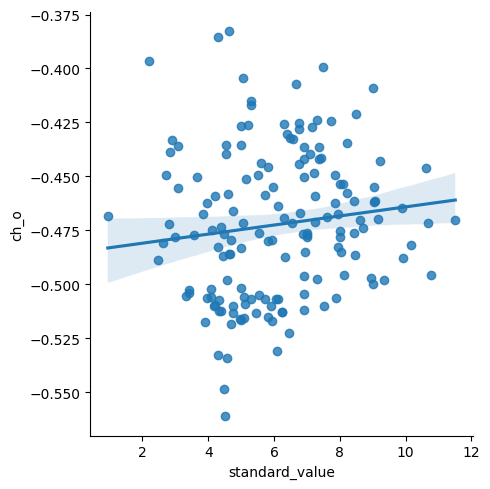

In [31]:
sns.lmplot(data=df[df['ch_o'] != 0], x="standard_value", y="ch_o")

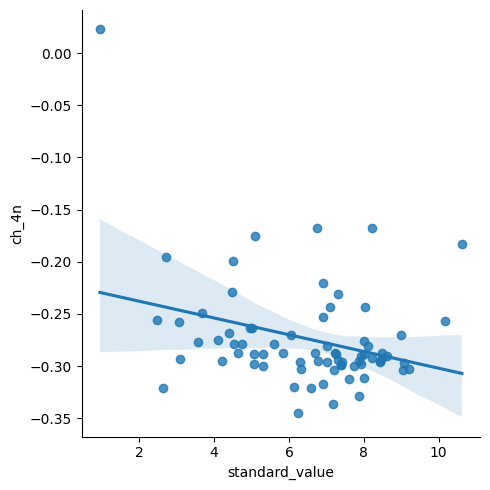

In [32]:
sns.lmplot(data=df[df['ch_4n'] != 0], x="standard_value", y="ch_4n")

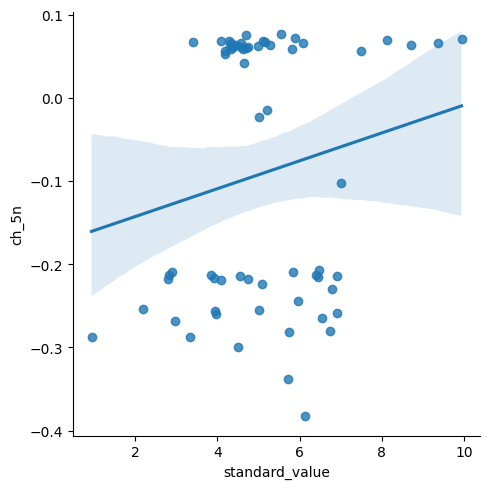

In [33]:
sns.lmplot(data=df[df['ch_5n'] != 0], x="standard_value", y="ch_5n")

In [34]:
df.to_csv('../data/clean_data/fpps_cl_q.csv', index=False)

## MCF7

### Cleaning

In [35]:
df = pd.read_csv('../data/raw_data/mcf7.csv', sep=';')
df.columns = [col.lower().replace(' ', '_') for col in df.columns]
df = df[[
    'molecule_chembl_id', 'molecular_weight', 'alogp',
    'smiles', 'standard_relation', 'standard_value',
    'standard_units', 'data_validity_comment', 'assay_description',
    'assay_organism',
]]

/tmp/ipykernel_7863/262791938.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/raw_data/mcf7.csv', sep=';')


In [36]:
df = df[df['assay_organism'] == 'Homo sapiens']
df = df[df['data_validity_comment'] != 'Outside typical range']
df = df[df['data_validity_comment'] != 'Potential missing data']
df = df[df['standard_units'] == 'nM']
df = df.dropna(subset=['smiles', 'standard_value',
                       'alogp', 'standard_relation',
                      'standard_units'])

In [37]:
df = df[df['standard_relation'] == "'='"]
df = df[['molecular_weight', 'smiles', 'standard_value', 'alogp']]
df['standard_value'] = np.log(df['standard_value'])

In [38]:
mean_sv = df.groupby('smiles')['standard_value'].mean()
df = df[~df['smiles'].duplicated()]
df = df.set_index('smiles')
df['standard_value'] = mean_sv

df = df.reset_index()

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30073 entries, 0 to 30072
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   smiles            30073 non-null  object 
 1   molecular_weight  30073 non-null  object 
 2   standard_value    30073 non-null  float64
 3   alogp             30073 non-null  object 
dtypes: float64(1), object(3)
memory usage: 939.9+ KB


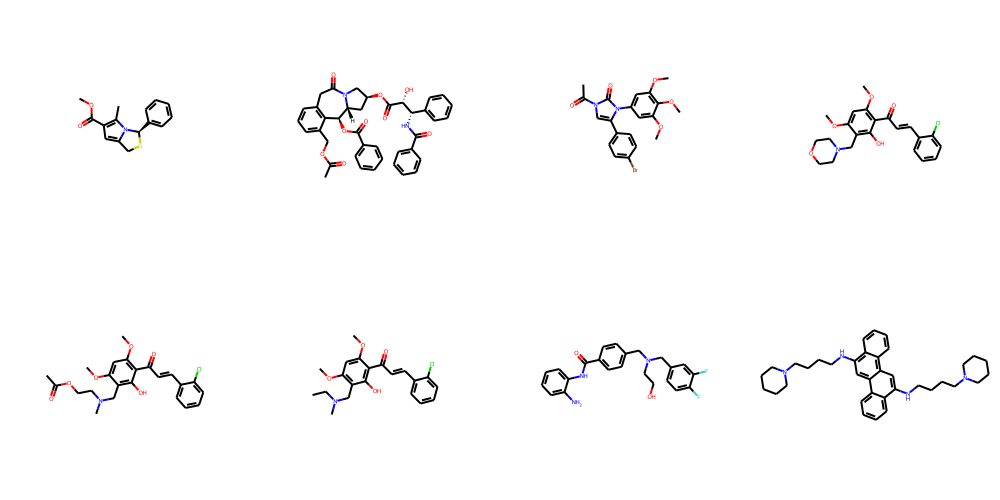

In [40]:
molecules = [Chem.MolFromSmiles(smiles) for smiles in df['smiles']][:8]
Draw.MolsToGridImage(molecules, molsPerRow=4, subImgSize=(250,250))

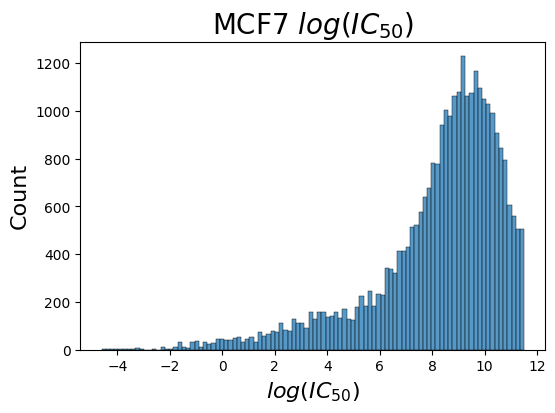

In [41]:
plt.figure(figsize=(6, 4))
sns.histplot(data=df, x='standard_value', bins=100)
plt.ylabel('Count', size=16)
plt.xlabel('$log(IC_{50})$', size=16) 
plt.title('MCF7 $log(IC_{50})$', size=20) 
  
# Display figure 
plt.show() 

In [42]:
df.to_csv('../data/clean_data/mcf7_cl.csv')

### Descryption

In [43]:
df_descr = get_descr_df(df)

  0%|          | 8/30073 [00:01<1:02:23,  8.03it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  0%|          | 63/30073 [00:08<1:04:57,  7.70it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  0%|          | 83/30073 [00:10<59:21,  8.42it/s]  

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  0%|          | 90/30073 [00:12<1:53:15,  4.41it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 17%|█▋        | 5159/30073 [10:58<2:21:23,  2.94it/s]

/home/jupyter/.local/lib/python3.10/site-packages/mordred/_matrix_attributes.py:251: RuntimeWarning: divide by zero encountered in scalar power
  s += (eig.vec[i, eig.max] * eig.vec[j, eig.max]) ** -0.5


 39%|███▉      | 11835/30073 [24:54<1:56:12,  2.62it/s]

/home/jupyter/.local/lib/python3.10/site-packages/mordred/_matrix_attributes.py:251: RuntimeWarning: invalid value encountered in scalar power
  s += (eig.vec[i, eig.max] * eig.vec[j, eig.max]) ** -0.5


 44%|████▎     | 13117/30073 [27:40<2:10:40,  2.16it/s]

/home/jupyter/.local/lib/python3.10/site-packages/mordred/_matrix_attributes.py:251: RuntimeWarning: invalid value encountered in scalar power
  s += (eig.vec[i, eig.max] * eig.vec[j, eig.max]) ** -0.5


 63%|██████▎   | 18903/30073 [39:52<2:11:10,  1.42it/s]

/home/jupyter/.local/lib/python3.10/site-packages/mordred/_matrix_attributes.py:251: RuntimeWarning: divide by zero encountered in scalar power
  s += (eig.vec[i, eig.max] * eig.vec[j, eig.max]) ** -0.5


100%|██████████| 30073/30073 [1:04:48<00:00,  7.73it/s]


In [44]:
df_descr.to_csv('../data/desc_data/mcf7_desc.csv', index=False)

## PC3

### Cleaning

In [45]:
df = pd.read_csv('../data/raw_data/pc3.csv', sep=';')
df.columns = [col.lower().replace(' ', '_') for col in df.columns]
df = df[[
    'molecule_chembl_id', 'molecular_weight', 'alogp',
    'smiles', 'standard_relation', 'standard_value',
    'standard_units', 'data_validity_comment', 'assay_description',
    'assay_organism',
]]

In [46]:
df = df[df['assay_organism'] == 'Homo sapiens']
df = df[df['data_validity_comment'] != 'Outside typical range']
df = df[df['standard_units'] == 'nM']
df = df.dropna(subset=['smiles', 'standard_value',
                       'alogp', 'standard_relation',
                      'standard_units'])

In [47]:
df = df[df['standard_relation'] == "'='"]
df = df[['molecular_weight', 'smiles', 'standard_value', 'alogp']]
df['standard_value'] = np.log(df['standard_value'])

In [48]:
mean_sv = df.groupby('smiles')['standard_value'].mean()
df = df[~df['smiles'].duplicated()]
df = df.set_index('smiles')
df['standard_value'] = mean_sv

df = df.reset_index()

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9071 entries, 0 to 9070
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   smiles            9071 non-null   object 
 1   molecular_weight  9071 non-null   float64
 2   standard_value    9071 non-null   float64
 3   alogp             9071 non-null   object 
dtypes: float64(2), object(2)
memory usage: 283.6+ KB


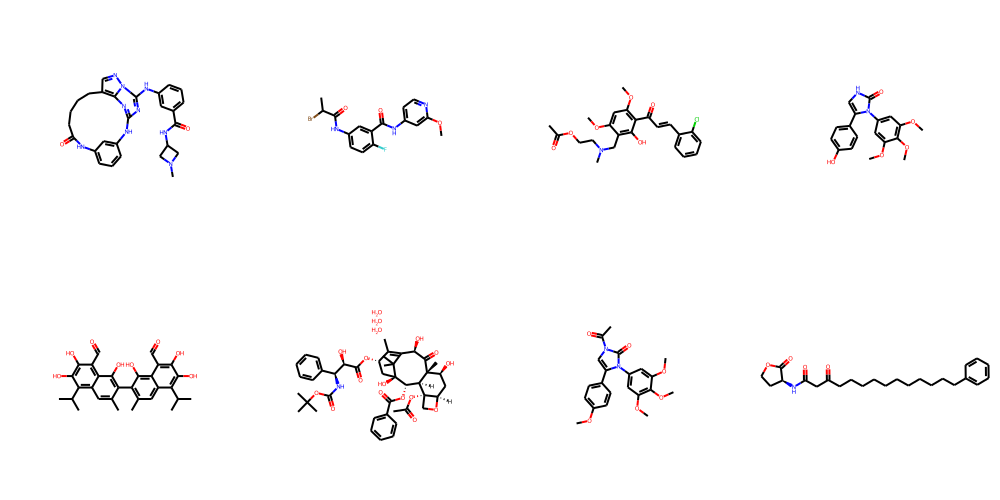

In [50]:
molecules = [Chem.MolFromSmiles(smiles) for smiles in df['smiles']][:8]
Draw.MolsToGridImage(molecules, molsPerRow=4, subImgSize=(250,250))

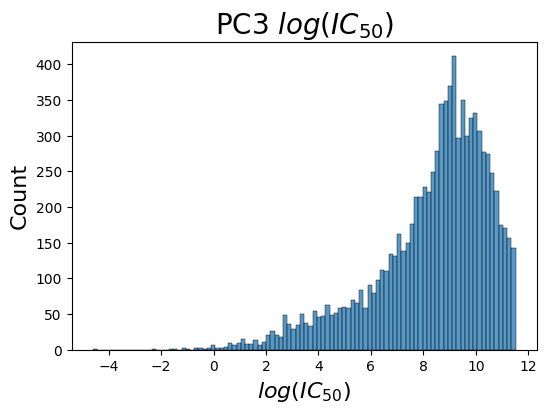

In [51]:
plt.figure(figsize=(6, 4))
sns.histplot(data=df, x='standard_value', bins=100)
plt.ylabel('Count', size=16)
plt.xlabel('$log(IC_{50})$', size=16) 
plt.title('PC3 $log(IC_{50})$', size=20) 
  
# Display figure 
plt.show() 

In [52]:
df.to_csv('../data/clean_data/pc3_cl.csv')

### Descryption

In [53]:
df_descr = get_descr_df(df)

  0%|          | 12/9071 [00:02<29:49,  5.06it/s] 

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  1%|▏         | 122/9071 [00:15<43:03,  3.46it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  2%|▏         | 142/9071 [00:17<41:19,  3.60it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  2%|▏         | 143/9071 [00:18<41:29,  3.59it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 9071/9071 [18:47<00:00,  8.04it/s]  


In [54]:
df_descr.to_csv('../data/desc_data/pc3_desc.csv', index=False)